Récupération du jeu de données

In [1]:
!tar -xzf test_technique.tar.gz --exclude=".*"

In [4]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import seaborn as sns
# import tensorflow_datasets as tfds
import albumentations as A
from functools import partial

import splitfolders

import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling, Layer, BatchNormalization, InputLayer

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint

In [5]:
batch_size = 32
img_width = 224
img_height = 224

path = os.path.abspath('./Test_Technique_Image/Neuroflux_disorder/')
outpath = './Test_Technique_Image'
classes = os.listdir(path)
classes

['EO', 'IO', 'IPTE', 'LO', 'PTE']

Après avoir récupéré le data set, nous allons le diviser en trois sous dossier. Un pour l'entraînement, un pour la validation et un pour les tests. Le split se fait avec un pourcentage de 70/20/10.

Etant donné le peu de données, nous mettons en place un ImageDataGenerator permettant l'application de filtres sur les données d'entraînement. Nous laissons cependant les données de validation et de test inchangées (seulement une normalisation).

In [8]:
train = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    batch_size=32,
    image_size=(32, 32),
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
)

val = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    batch_size=32,
    image_size=(32, 32),
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
)


Found 1296 files belonging to 5 classes.
Using 1037 files for training.
Found 1296 files belonging to 5 classes.
Using 259 files for validation.


Liste des classes et leur représentation dans le dataset :

[('PTE', 580), ('LO', 240), ('EO', 233), ('IPTE', 171), ('IO', 72)]


Liste des labels :

['PTE', 'LO', 'EO', 'IPTE', 'IO']




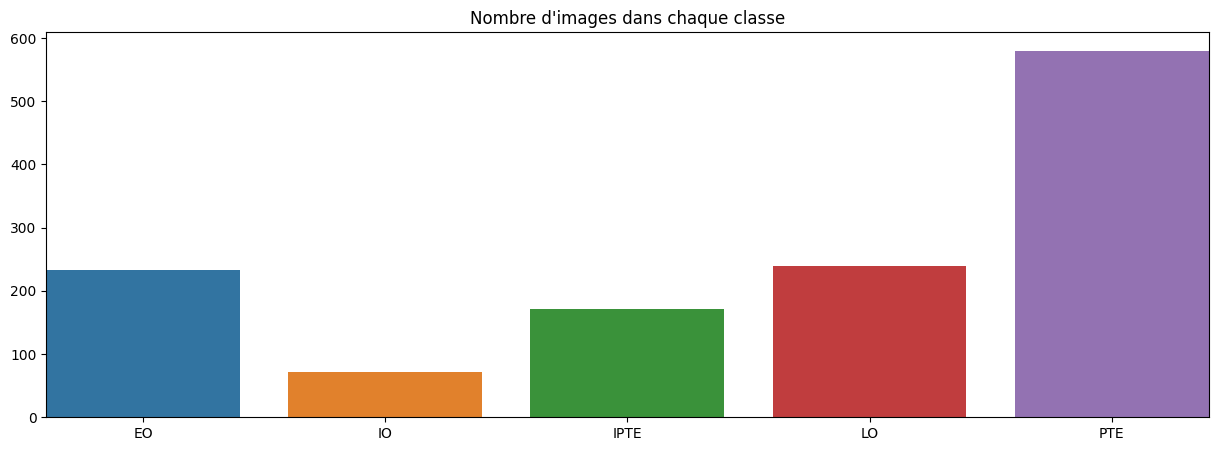

In [9]:
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))


# ------------- Liste des classes et leur représentation dans le dataset -------------
classes_and_number = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:13]
print("Liste des classes et leur représentation dans le dataset :\n")
print(classes_and_number)
print("\n")


# ------------- Liste des labels -------------
labels = [i[0] for i in classes_and_number]
print("Liste des labels :\n")
print(labels)
print("\n")


# ------------- Plotting du nombre d'images dans chaque classe -------------
Y = []
for c in classes:
    if c in labels:
        dir_path = os.path.join(path, c)
        label = labels.index(c)
        for i in os.listdir(dir_path):
            Y.append(label)

obj = Counter(Y)

fig = plt.figure(figsize = (15, 5))
sns.barplot(x = [labels[i] for i in obj.keys()], y = list(obj.values())).set_title("Nombre d'images dans chaque classe")
plt.margins(x = 0)
plt.show()

On peut voir que le jeu de données est déséquilibré et que cela va fausser l'entraînement de notre réseau de convolution. Nous allons donc mettre en place des poids pour que le réseau apprenne correctement.

In [10]:
counts = {}
total_files = 0
for c in classes:
    length = len(os.listdir(os.path.join(path, c)))
    counts[c] = length
    total_files += length
    
for k, v in counts.items():
    counts[k] = 1 / v * 100

coeff = {}
for i in range(len(counts)):
    coeff[i] = counts[classes[i]]
    
coeff

{0: 0.4291845493562232,
 1: 1.3888888888888888,
 2: 0.5847953216374269,
 3: 0.4166666666666667,
 4: 0.1724137931034483}

In [11]:
flip = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomFlip("horizontal"),
    ]
)
rot = Sequential(
    [
        layers.RandomRotation(0.5),
        layers.RandomRotation(factor=0.15),
        layers.RandomZoom(0.2, 0.3),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1),
    ]
)

rot2 = Sequential(
    [
        layers.RandomRotation(0.5),
        layers.RandomZoom((-0.2, -0.3)),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.8),
    ]
)

augmented_rot = train.map(
  lambda x, y: (rot(x, training=True), y))

augmented_rot2 = train.map(
  lambda x, y: (rot2(x, training=True), y))

augmented_flip = train.map(
  lambda x, y: (flip(x, training=True), y))

train = train.concatenate(augmented_flip).concatenate(augmented_rot).concatenate(rot2)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


AttributeError: 'Sequential' object has no attribute 'element_spec'

In [31]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Sequential()
model.add(Rescaling(1./255))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))


model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())


model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))


model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [32]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'Recall'])

In [33]:
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

In [35]:
fit = model.fit(train,epochs=100, validation_data=val, class_weight = coeff) #,callbacks=[mcp_save, reduce_lr_loss])

Epoch 1/100
33/33 [==============================] - 4s 129ms/step - loss: 0.4014 - accuracy: 0.4667 - recall: 0.3173 - val_loss: 1.4711 - val_accuracy: 0.3243 - val_recall: 0.2008
Epoch 2/100
33/33 [==============================] - 4s 126ms/step - loss: 0.4295 - accuracy: 0.4446 - recall: 0.3211 - val_loss: 1.4971 - val_accuracy: 0.3359 - val_recall: 0.1737
Epoch 3/100
33/33 [==============================] - 4s 132ms/step - loss: 0.4073 - accuracy: 0.4426 - recall: 0.3259 - val_loss: 1.6227 - val_accuracy: 0.3050 - val_recall: 0.1583
Epoch 4/100
33/33 [==============================] - 4s 134ms/step - loss: 0.3874 - accuracy: 0.4744 - recall: 0.3394 - val_loss: 1.5650 - val_accuracy: 0.3359 - val_recall: 0.1931
Epoch 5/100
33/33 [==============================] - 4s 126ms/step - loss: 0.4050 - accuracy: 0.4629 - recall: 0.3549 - val_loss: 1.5680 - val_accuracy: 0.3282 - val_recall: 0.2008
Epoch 6/100
33/33 [==============================] - 4s 130ms/step - loss: 0.3529 - accuracy: 0

33/33 [==============================] - 4s 123ms/step - loss: 0.2429 - accuracy: 0.6461 - recall: 0.5516 - val_loss: 1.5215 - val_accuracy: 0.4093 - val_recall: 0.2896
Epoch 47/100
33/33 [==============================] - 4s 130ms/step - loss: 0.2362 - accuracy: 0.6480 - recall: 0.5603 - val_loss: 1.6394 - val_accuracy: 0.3784 - val_recall: 0.2548
Epoch 48/100
33/33 [==============================] - 4s 128ms/step - loss: 0.2365 - accuracy: 0.6442 - recall: 0.5564 - val_loss: 1.5146 - val_accuracy: 0.4440 - val_recall: 0.3050
Epoch 49/100
33/33 [==============================] - 5s 136ms/step - loss: 0.2164 - accuracy: 0.6856 - recall: 0.5911 - val_loss: 1.5693 - val_accuracy: 0.4054 - val_recall: 0.2973
Epoch 50/100
33/33 [==============================] - 4s 127ms/step - loss: 0.2240 - accuracy: 0.6673 - recall: 0.5882 - val_loss: 1.5429 - val_accuracy: 0.4324 - val_recall: 0.3320
Epoch 51/100
33/33 [==============================] - 4s 123ms/step - loss: 0.2300 - accuracy: 0.6615 -

33/33 [==============================] - 5s 138ms/step - loss: 0.1163 - accuracy: 0.8370 - recall: 0.7850 - val_loss: 1.7425 - val_accuracy: 0.4479 - val_recall: 0.4015
Epoch 92/100
33/33 [==============================] - 5s 138ms/step - loss: 0.1224 - accuracy: 0.8284 - recall: 0.8023 - val_loss: 1.8438 - val_accuracy: 0.4479 - val_recall: 0.3977
Epoch 93/100
33/33 [==============================] - 5s 140ms/step - loss: 0.1088 - accuracy: 0.8419 - recall: 0.8071 - val_loss: 1.8149 - val_accuracy: 0.4595 - val_recall: 0.4093
Epoch 94/100
33/33 [==============================] - 4s 127ms/step - loss: 0.1050 - accuracy: 0.8534 - recall: 0.8206 - val_loss: 1.7998 - val_accuracy: 0.4286 - val_recall: 0.4054
Epoch 95/100
33/33 [==============================] - 4s 124ms/step - loss: 0.1186 - accuracy: 0.8409 - recall: 0.8071 - val_loss: 1.7526 - val_accuracy: 0.4170 - val_recall: 0.3822
Epoch 96/100
33/33 [==============================] - 4s 123ms/step - loss: 0.0988 - accuracy: 0.8592 -

In [37]:
score = model.evaluate(val)

9/9 [==============================] - 0s 15ms/step - loss: 1.8433 - accuracy: 0.4440 - recall: 0.4131


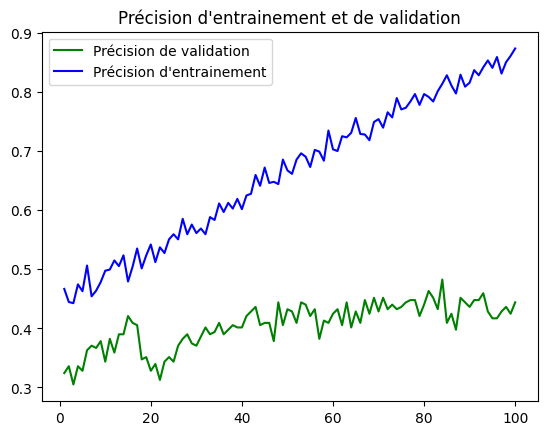

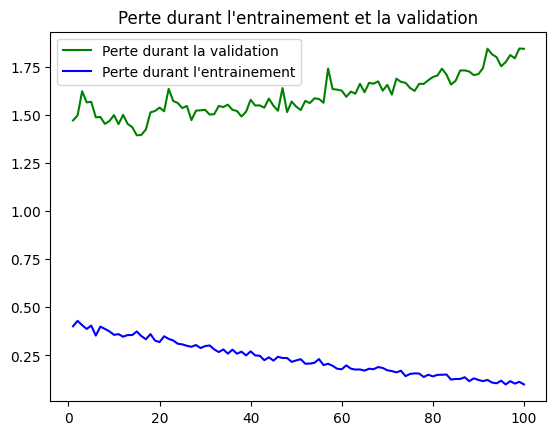

In [38]:
def training_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, val_acc, 'g', label="Précision de validation")
    plt.plot(epochs, acc, 'b', label="Précision d'entrainement")
    plt.title("Précision d'entrainement et de validation")
    plt.legend()
    plt.figure()
    plt.plot(epochs, val_loss, 'g', label="Perte durant la validation")
    plt.plot(epochs, loss, 'b', label="Perte durant l'entrainement")
    plt.title("Perte durant l'entrainement et la validation")
    plt.legend()
    plt.show()

training_plot(fit)

Avec l'observation des metrics, on peut voir un overfitting du réseau, sûrement du au manque de données d'entrées.

1/1 [==============================] - 0s 150ms/step
Matrice de confusion brute :
[[13  1  1  4 23]
 [ 4  0  1  0  6]
 [ 2  0 16  8 16]
 [ 3  3  0 25 23]
 [12  5  4 28 61]]




C:\Users\SebLa\AppData\Local\Temp\ipykernel_7104\369173688.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\SebLa\AppData\Local\Temp\ipykernel_7104\369173688.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


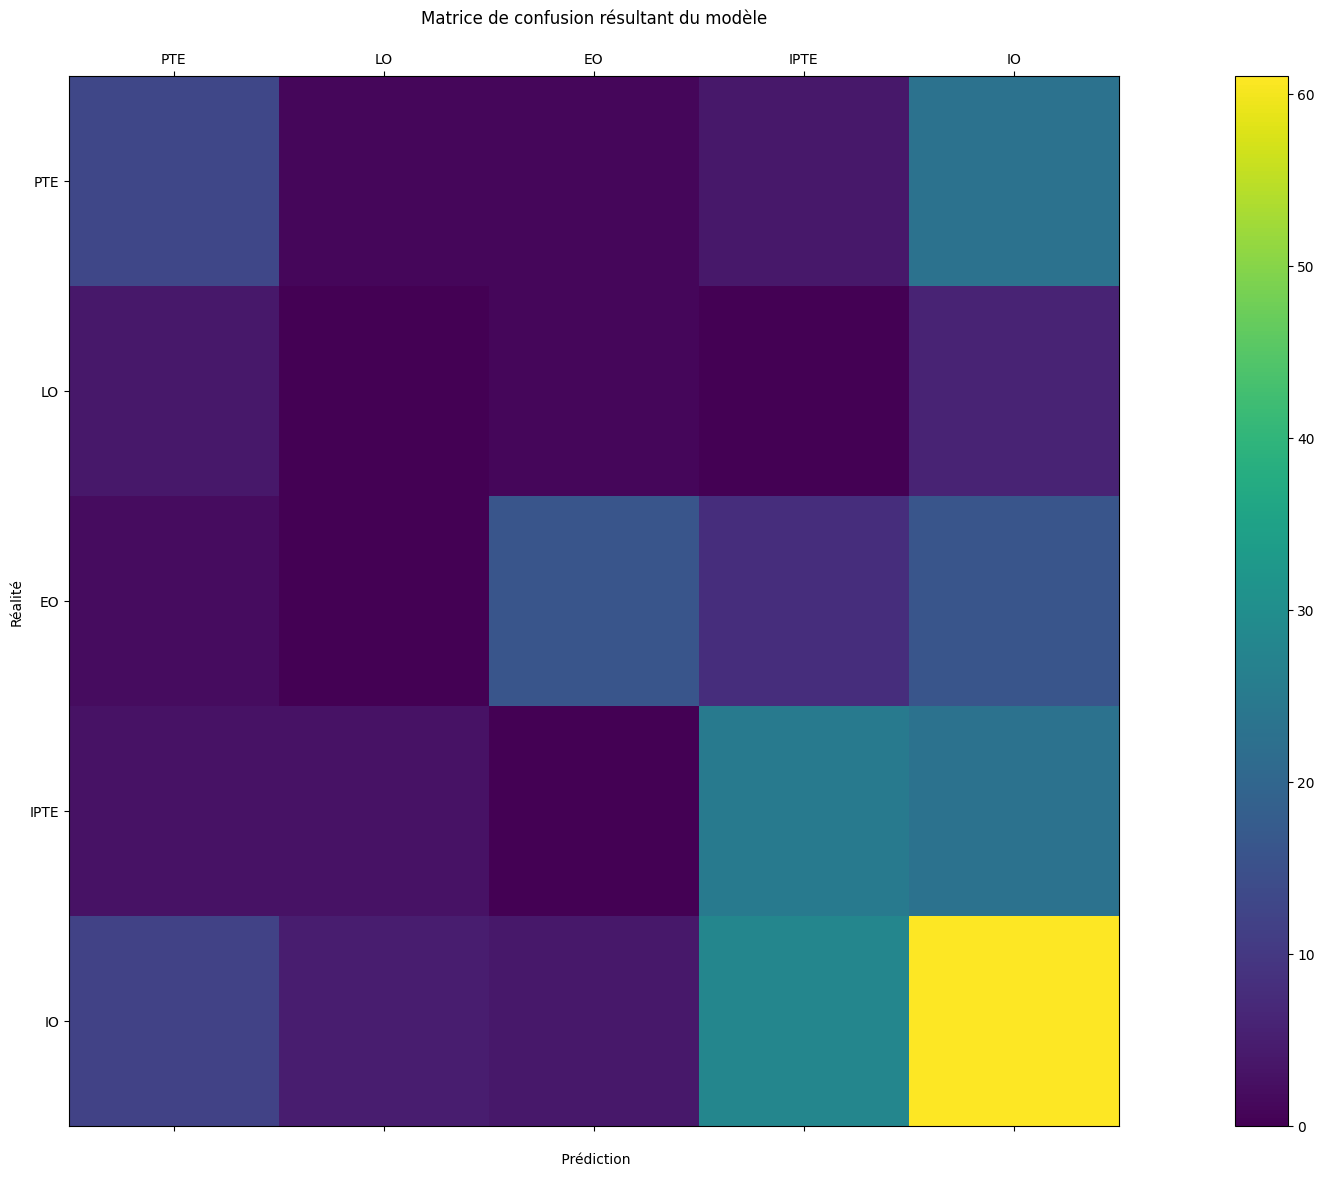

In [39]:
from sklearn.metrics import confusion_matrix
from numpy import argmax


# ------------- Calculs préliminaires -------------
y_true = []
y_pred = []
for x, y in val:
    y = tf.argmax(y, axis = 1)
    y_true.append(y)
    y_pred.append(tf.argmax(model.predict(x), axis = 1))

y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)


# ------------- Matrice de confusion -------------
cm = confusion_matrix(y_true, y_pred)

print("Matrice de confusion brute :")
print(cm)
print("\n")

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Matrice de confusion')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('\n Prédiction')
plt.ylabel('Réalité')
plt.title("Matrice de confusion résultant du modèle\n")
plt.show()

In [40]:
from sklearn.metrics import classification_report

print("Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=2))

Rapport de classification :

              precision    recall  f1-score   support

          EO       0.38      0.31      0.34        42
          IO       0.00      0.00      0.00        11
        IPTE       0.73      0.38      0.50        42
          LO       0.38      0.46      0.42        54
         PTE       0.47      0.55      0.51       110

    accuracy                           0.44       259
   macro avg       0.39      0.34      0.35       259
weighted avg       0.46      0.44      0.44       259



Ces résultats nous montre que la précision sur la phase IPTE est bonne mais que l'IO n'est jamais reconnu malgré la mise en place de poids

# Transfer Learning

Pour le transfert learning j'ai décidé d'utiliser un EfficientNETB0 car c'est un réseau de convolution souvent utilisé dans les sujets de radiologie. 

In [41]:
from keras.applications import EfficientNetB0
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(32, 32, 3))

In [42]:
model2 = effnet.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(rate=0.5)(model2)
model2 = tf.keras.layers.Dense(5,activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=effnet.input, outputs = model2)

In [43]:
model2.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [44]:
fit2 = model2.fit(train,epochs=20, validation_data=val)#, class_weight = coeff,callbacks=[mcp_save, reduce_lr_loss])

Epoch 1/20
33/33 [==============================] - 22s 185ms/step - loss: 2.0817 - accuracy: 0.2507 - val_loss: 1.9474 - val_accuracy: 0.0618
Epoch 2/20
33/33 [==============================] - 5s 142ms/step - loss: 1.7517 - accuracy: 0.3549 - val_loss: 1.8045 - val_accuracy: 0.1699
Epoch 3/20
33/33 [==============================] - 5s 145ms/step - loss: 1.5986 - accuracy: 0.3915 - val_loss: 1.9006 - val_accuracy: 0.1004
Epoch 4/20
33/33 [==============================] - 5s 155ms/step - loss: 1.4830 - accuracy: 0.4098 - val_loss: 1.7683 - val_accuracy: 0.4247
Epoch 5/20
33/33 [==============================] - 5s 149ms/step - loss: 1.3314 - accuracy: 0.4773 - val_loss: 1.6885 - val_accuracy: 0.2625
Epoch 6/20
33/33 [==============================] - 5s 136ms/step - loss: 1.2315 - accuracy: 0.5063 - val_loss: 1.8695 - val_accuracy: 0.2934
Epoch 7/20
33/33 [==============================] - 5s 137ms/step - loss: 1.2222 - accuracy: 0.5207 - val_loss: 1.9209 - val_accuracy: 0.4093
Epoch

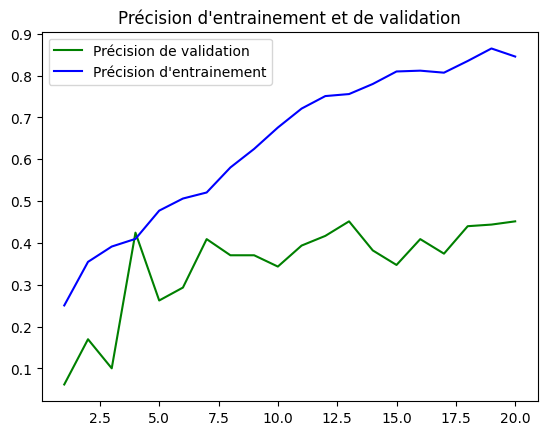

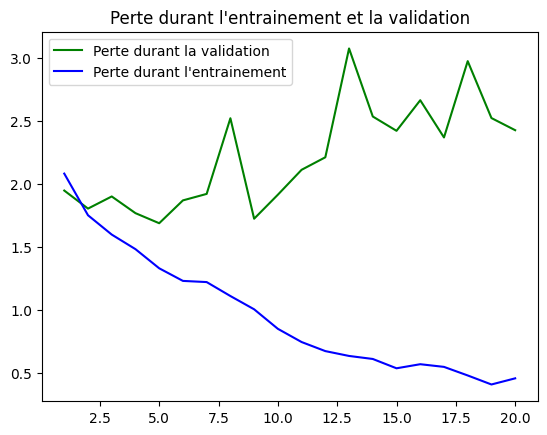

In [46]:
training_plot(fit2)

1/1 [==============================] - 1s 1s/step
Matrice de confusion brute :
[[14  2  2  5 19]
 [ 0  1  1  1  8]
 [ 3  0 16  7 16]
 [ 7  2  2 17 26]
 [14  7  4 16 69]]




C:\Users\SebLa\AppData\Local\Temp\ipykernel_7104\403642471.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\SebLa\AppData\Local\Temp\ipykernel_7104\403642471.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


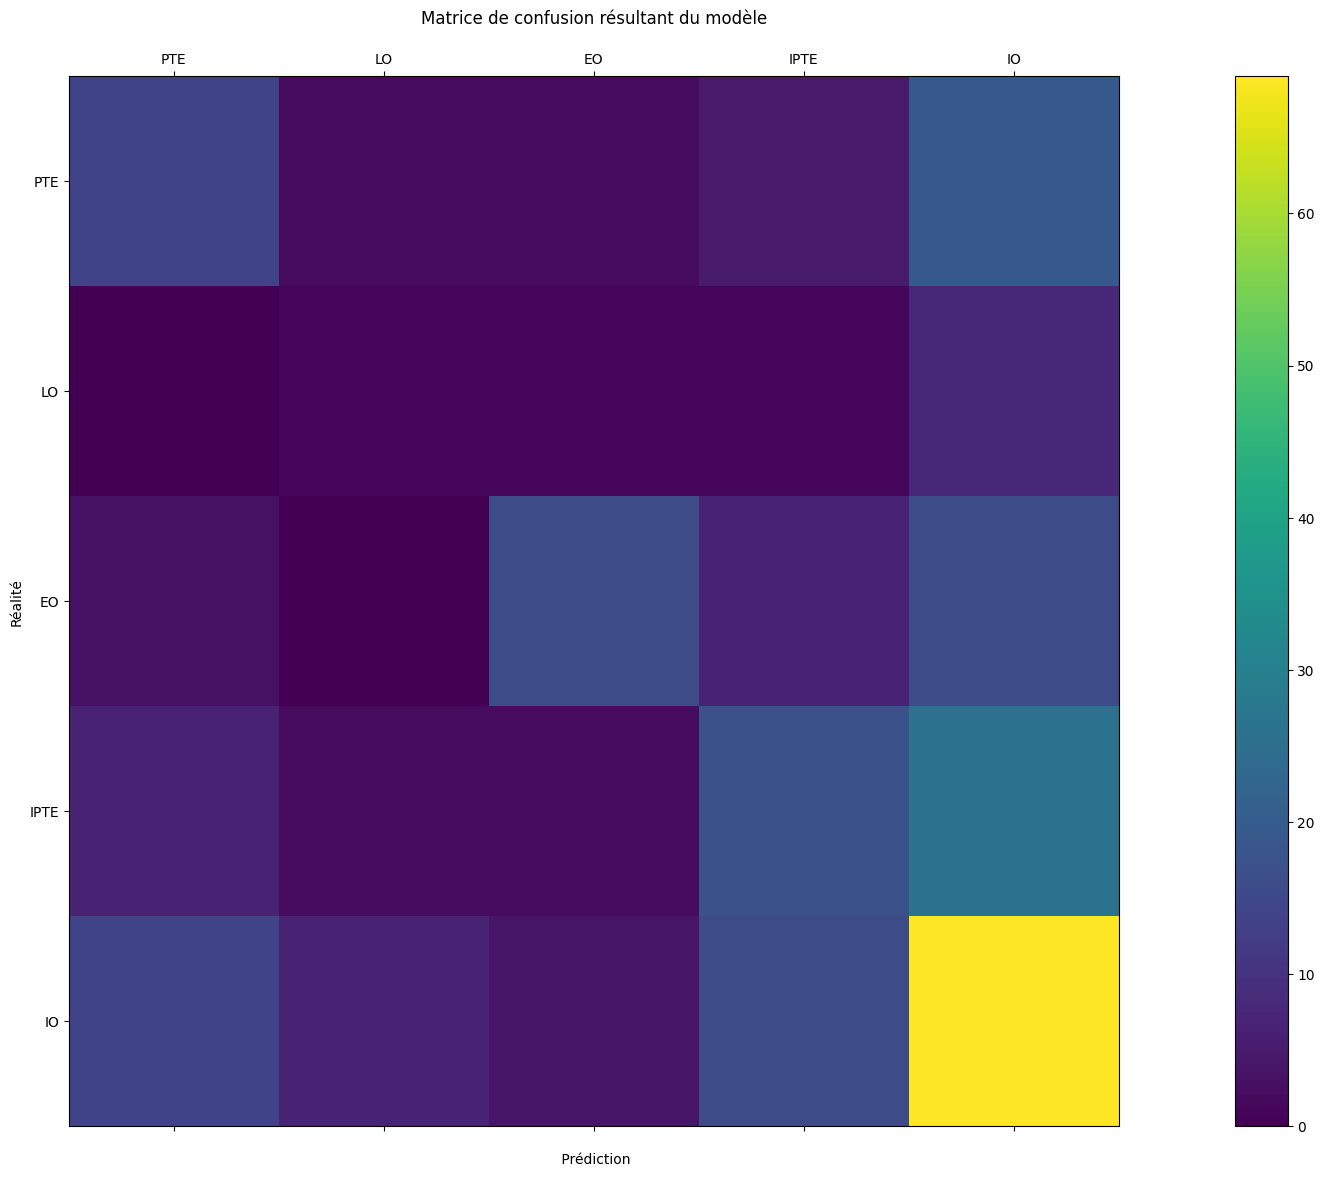

In [47]:
y_true = []
y_pred = []
for x, y in val:
    y = tf.argmax(y, axis = 1)
    y_true.append(y)
    y_pred.append(tf.argmax(model2.predict(x), axis = 1))

y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)


# ------------- Matrice de confusion -------------
cm = confusion_matrix(y_true, y_pred)

print("Matrice de confusion brute :")
print(cm)
print("\n")

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Matrice de confusion')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('\n Prédiction')
plt.ylabel('Réalité')
plt.title("Matrice de confusion résultant du modèle\n")
plt.show()

In [48]:
print("Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=2))

Rapport de classification :

              precision    recall  f1-score   support

          EO       0.37      0.33      0.35        42
          IO       0.08      0.09      0.09        11
        IPTE       0.64      0.38      0.48        42
          LO       0.37      0.31      0.34        54
         PTE       0.50      0.63      0.56       110

    accuracy                           0.45       259
   macro avg       0.39      0.35      0.36       259
weighted avg       0.46      0.45      0.45       259

